In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.optim import AdamW
from tqdm import tqdm
import os

2025-05-16 05:32:09.732110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747373529.940209      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747373530.003126      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)
dataset = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Split into train and test
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset['sentiment'])

# Display basic info
print(train_df.info())
print(train_df['sentiment'].value_counts(normalize=True))

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 47808 to 27491
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 937.5+ KB
None
sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64


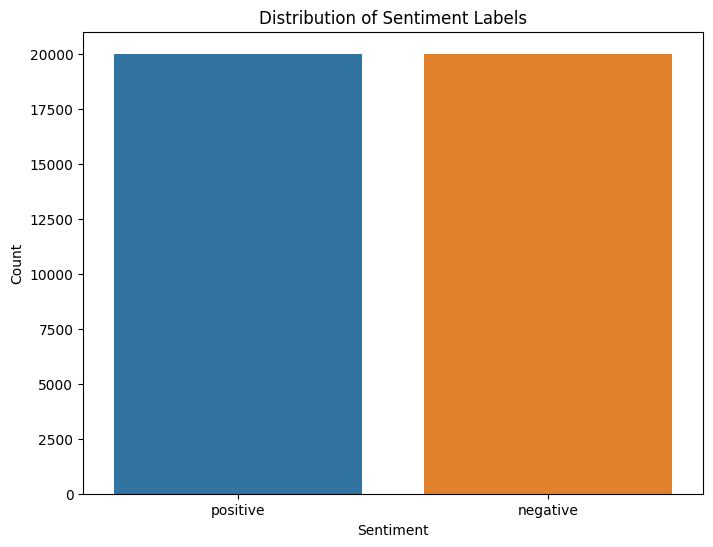

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=train_df)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [5]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Convert sentiment labels to integers
label_map = {'positive': 1, 'negative': 0}
train_texts = train_df['review'].tolist()
train_labels = [label_map[label] for label in train_df['sentiment']]

test_texts = test_df['review'].tolist()
test_labels = [label_map[label] for label in test_df['sentiment']]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
# Preprocessing function
def preprocess_data(texts, labels, max_length=256):
    encoded = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': torch.tensor(labels)
    }

In [7]:
# Preprocess training and testing data
train_data = preprocess_data(train_texts, train_labels)
test_data = preprocess_data(test_texts, test_labels)

In [8]:
# Initialize model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create DataLoader
train_dataset = TensorDataset(train_data['input_ids'], train_data['attention_mask'], train_data['labels'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [11]:
# Config

num_epochs = 3
checkpoint_dir = 'bert_checkpoints'
start_epoch = 0  # Will be updated if checkpoint exists

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
optimizer = AdamW(model.parameters(), lr=2e-5)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Resume from latest checkpoint if available
latest_checkpoint = None
if os.path.exists(checkpoint_dir):
    checkpoints = sorted(os.listdir(checkpoint_dir))
    if checkpoints:
        latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
        print(f"Resuming from checkpoint: {latest_checkpoint}")
        model = BertForSequenceClassification.from_pretrained(latest_checkpoint)
        tokenizer = BertTokenizer.from_pretrained(latest_checkpoint)

        # Load optimizer and epoch
        checkpoint = torch.load(os.path.join(latest_checkpoint, 'training_state.pt'))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']

# Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss / len(train_loader)}")

    # Save checkpoint
    epoch_dir = os.path.join(checkpoint_dir, f'epoch_{epoch+1}')
    os.makedirs(epoch_dir, exist_ok=True)
    model.save_pretrained(epoch_dir)
    tokenizer.save_pretrained(epoch_dir)
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(epoch_dir, 'training_state.pt'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Loss: 0.24971513016521932


Epoch 2/3 - Loss: 0.14086953194886445


Epoch 3/3 - Loss: 0.07752943842355162


In [12]:
# Save the model and tokenizer
model.save_pretrained('bert_sentiment_model')
tokenizer.save_pretrained('bert_sentiment_model')

('bert_sentiment_model/tokenizer_config.json',
 'bert_sentiment_model/special_tokens_map.json',
 'bert_sentiment_model/vocab.txt',
 'bert_sentiment_model/added_tokens.json')

In [13]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
test_dataset = TensorDataset(test_data['input_ids'], test_data['attention_mask'], test_data['labels'])
test_loader = DataLoader(test_dataset, batch_size=32)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy}")
print(classification_report(all_labels, all_preds))

Accuracy: 0.9263
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5000
           1       0.92      0.94      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [14]:
def predict_sentiment(text):
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1)
    return "Positive" if pred.item() == 1 else "Negative"

# Example usage
# Test with new sentences
print(predict_sentiment("I love this movie!"))  
print(predict_sentiment("This movie was terrible."))

Positive
Negative
